# IMERG w/ h5py

The Integrated Multi-satellitE Retrievals for GPM (IMERG) is the unified U.S. algorithm that provides the multi-satellite precipitation product for the U.S. GPM team.

Minor Version 06B is the current version of the data set. Older versions will no longer be available and have been superseded by Version 06B.

The precipitation estimates from the various precipitation-relevant satellite passive microwave (PMW) sensors comprising the GPM constellation are computed using the 2017 version of the Goddard Profiling Algorithm (GPROF2017), then gridded, intercalibrated to the GPM Combined Ku Radar-Radiometer Algorithm (CORRA) product, and merged into half-hourly 0.1°x0.1° (roughly 10x10 km) fields. Note that CORRA is adjusted to the monthly Global Precipitation Climatology Project (GPCP) Satellite-Gauge (SG) product over high-latitude ocean and tropical land to correct known biases.

See: https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGM_06/summary for more information

This sample contains data from IMERG files for the temporal coverage for the day 09-01-2022 at 30 min intervals.  The source data is aggregated so that the time dimension is expand from an extent of 1 (for the original files) to 48, covering the entire date range. 

In [1]:
%matplotlib inline
from datetime import datetime
import h5pyd as h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation

In [2]:
# open domain in read-only mode
f = h5py.File("hdf5://shared/NASA/IMERG/imerg.2022.09.h5")

In [3]:
# list contents of file - contains just one top-level object "Grid"
list(f)

['Grid']

In [4]:
# get reference to Grid group and list contents of sub-group
grid_grp = f["Grid"]
list(grid_grp)

['HQobservationTime',
 'HQprecipSource',
 'HQprecipitation',
 'IRkalmanFilterWeight',
 'IRprecipitation',
 'lat',
 'lat_bnds',
 'latv',
 'lon',
 'lon_bnds',
 'lonv',
 'nv',
 'precipitationCal',
 'precipitationQualityIndex',
 'precipitationUncal',
 'probabilityLiquidPrecipitation',
 'randomError',
 'time',
 'time_bnds']

In [5]:
# get description of each object in grid group
for k in grid_grp:
    h5obj = grid_grp[k]
    print(f"{k}: {h5obj}")

HQobservationTime: <HDF5 dataset "HQobservationTime": shape (48, 3600, 1800), type "<i2">
HQprecipSource: <HDF5 dataset "HQprecipSource": shape (48, 3600, 1800), type "<i2">
HQprecipitation: <HDF5 dataset "HQprecipitation": shape (48, 3600, 1800), type "<f4">
IRkalmanFilterWeight: <HDF5 dataset "IRkalmanFilterWeight": shape (48, 3600, 1800), type "<i2">
IRprecipitation: <HDF5 dataset "IRprecipitation": shape (48, 3600, 1800), type "<f4">
lat: <HDF5 dataset "lat": shape (1800,), type "<f4">
lat_bnds: <HDF5 dataset "lat_bnds": shape (1800, 2), type "<f4">
latv: <HDF5 dataset "latv": shape (2,), type "<i4">
lon: <HDF5 dataset "lon": shape (3600,), type "<f4">
lon_bnds: <HDF5 dataset "lon_bnds": shape (3600, 2), type "<f4">
lonv: <HDF5 dataset "lonv": shape (2,), type "<i4">
nv: <HDF5 dataset "nv": shape (2,), type "<i4">
precipitationCal: <HDF5 dataset "precipitationCal": shape (48, 3600, 1800), type "<f4">
precipitationQualityIndex: <HDF5 dataset "precipitationQualityIndex": shape (48, 3

In [6]:
# get reference to precipitation dataset
precip = grid_grp["precipitationCal"]  # f["/Grid/precipitationCal"] would be equivlanet

In [7]:
# take a look at the attributes attached to this dataset
for k in precip.attrs:
    attr = precip.attrs[k]
    print(f"{k}: {attr}")

DimensionNames: b'time,lon,lat'
Units: b'mm/hr'
units: b'mm/hr'
coordinates: b'time lon lat'
_FillValue: -9999.900390625
CodeMissingValue: b'-9999.9'
DIMENSION_LIST: [array([b'datasets/d-fbb9209a-7946b30c-c0b1-c6ec7b-22de8a'], dtype='|S48')
 array([b'datasets/d-fbb9209a-7946b30c-a4be-173238-90ec41'], dtype='|S48')
 array([b'datasets/d-fbb9209a-7946b30c-a150-0300be-17f16b'], dtype='|S48')]


In [8]:
# get dimensions of dataset
precip.shape

(48, 3600, 1800)

In [9]:
# chunk shape shows how the datsaet is internally organized
precip.chunks

(1, 290, 1800)

In [10]:
# get dataset type
precip.dtype

dtype('float32')

In [11]:
# fillvalue is default value for uninitialized elements
precip.fillvalue

1.9140163e-05

In [12]:
# dataset uses gzip compression
precip.compression

'gzip'

In [13]:
# get the number of MBs (uncompressed) in the dataset
(np.prod(precip.shape) * precip.dtype.itemsize) // (1024*1024)

1186

In [14]:
# one time slice is small enough that we can read the entire time step 
# entirely into memory
%time data = precip[0,:,:]

CPU times: user 114 ms, sys: 47.2 ms, total: 161 ms
Wall time: 283 ms


In [15]:
# note the rank got reduced since first axis has just one element
data.shape

(3600, 1800)

In [16]:
# min value of -9999.9 is likely used to indicate non-relevant items
data.min(), data.max(), data.mean()

(-9999.9, 74.68014, -2211.4714)

In [17]:
# get just the positive values
non_fill = data[data > 0]

In [18]:
# number of elements in slice
np.prod(data.shape)

6480000

In [19]:
# number of non-fill values
len(non_fill)

781611

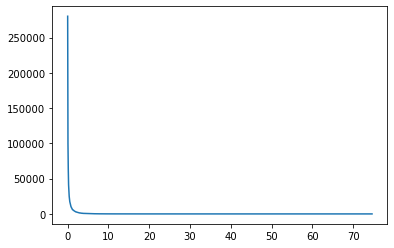

In [20]:
# plot a histogram
histo = np.histogram(non_fill, bins=1000)
plt.plot(histo[1][:-1], histo[0])

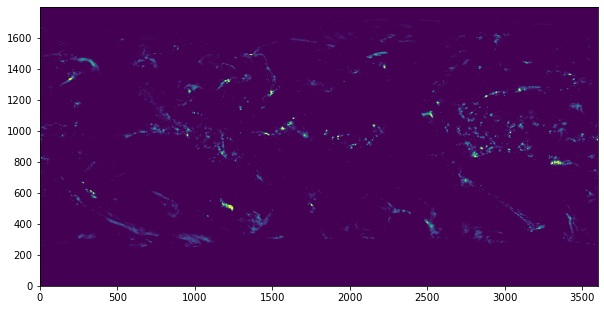

In [21]:
# try plotting the data
# transpose array so x-axis will be the longitude dimension
plt.figure(1, figsize=(10,10),dpi=72)
plt.imshow(np.transpose(data), origin="lower", vmin=0, vmax=10.0)  

In [22]:
# dimension scales are one-dimensional datasets that can be used to 
# provide coordinate values along each dimension of the parent dataset
len(precip.dims)

3

In [23]:
# each dimension can have multiple scales, but in this case
# there is one scale per dimension
for i in range(len(precip.dims)):
    dimscale = precip.dims[i]
    print(dimscale[0])

<HDF5 dataset "time": shape (48,), type "<i4">
<HDF5 dataset "lon": shape (3600,), type "<f4">
<HDF5 dataset "lat": shape (1800,), type "<f4">


In [24]:
dimscale = precip.dims[0]
time_dset = dimscale[0]
time_dset

<HDF5 dataset "time": shape (48,), type "<i4">

In [25]:
# time values are in seconds after epoch
time_dset[...]

array([1630454400, 1630456200, 1630458000, 1630459800, 1630461600,
       1630463400, 1630465200, 1630467000, 1630468800, 1630470600,
       1630472400, 1630474200, 1630476000, 1630477800, 1630479600,
       1630481400, 1630483200, 1630485000, 1630486800, 1630488600,
       1630490400, 1630492200, 1630494000, 1630495800, 1630497600,
       1630499400, 1630501200, 1630503000, 1630504800, 1630506600,
       1630508400, 1630510200, 1630512000, 1630513800, 1630515600,
       1630517400, 1630519200, 1630521000, 1630522800, 1630524600,
       1630526400, 1630528200, 1630530000, 1630531800, 1630533600,
       1630535400, 1630537200, 1630539000], dtype=int32)

In [26]:
print(datetime.fromtimestamp(time_dset[0]))

2021-09-01 00:00:00


In [27]:
print(datetime.fromtimestamp(time_dset[-1]))

2021-09-01 23:30:00


In [28]:
%%time
# accumlate the other time steps into our array
for i in range(1, precip.shape[0]):
    dt_val = datetime.fromtimestamp(time_dset[i])
    print("getting timeslice:", dt_val)
    arr = precip[i,:,:]
    np.add(data, arr, out=data, where="data2 > 0.0")

getting timeslice: 2021-09-01 00:30:00
getting timeslice: 2021-09-01 01:00:00
getting timeslice: 2021-09-01 01:30:00
getting timeslice: 2021-09-01 02:00:00
getting timeslice: 2021-09-01 02:30:00
getting timeslice: 2021-09-01 03:00:00
getting timeslice: 2021-09-01 03:30:00
getting timeslice: 2021-09-01 04:00:00
getting timeslice: 2021-09-01 04:30:00
getting timeslice: 2021-09-01 05:00:00
getting timeslice: 2021-09-01 05:30:00
getting timeslice: 2021-09-01 06:00:00
getting timeslice: 2021-09-01 06:30:00
getting timeslice: 2021-09-01 07:00:00
getting timeslice: 2021-09-01 07:30:00
getting timeslice: 2021-09-01 08:00:00
getting timeslice: 2021-09-01 08:30:00
getting timeslice: 2021-09-01 09:00:00
getting timeslice: 2021-09-01 09:30:00
getting timeslice: 2021-09-01 10:00:00
getting timeslice: 2021-09-01 10:30:00
getting timeslice: 2021-09-01 11:00:00
getting timeslice: 2021-09-01 11:30:00
getting timeslice: 2021-09-01 12:00:00
getting timeslice: 2021-09-01 12:30:00
getting timeslice: 2021-0

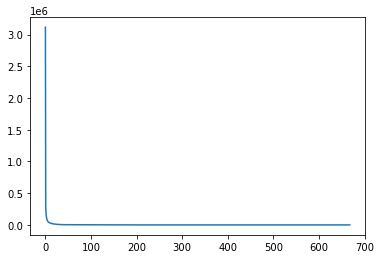

In [29]:
non_fill = data[data > -1]
histo = np.histogram(non_fill, bins=1000)
plt.plot(histo[1][:-1], histo[0])

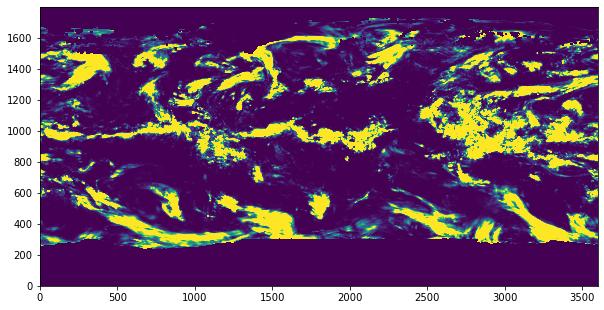

In [30]:
plt.figure(1, figsize=(10,10),dpi=72)
plt.imshow(np.transpose(data), origin="lower", vmin=0, vmax=10.0)